# Estudo de Caso – Modelo de Admissão de Crédito

# **Part 1 - Problema de Negócio**

**Projeto de Data Science**

**Contexto do Negócio**

A empresa busca aprimorar seu processo de admissão de clientes com o objetivo de reduzir o risco de inadimplência e aumentar a qualidade da carteira de crédito.

Atualmente, decisões de concessão podem resultar em:

* Perdas financeiras associadas a atrasos superiores a 30 dias
* Aumento do risco global da carteira
* Ineficiência no processo de aprovação de crédito

Diante desse cenário, torna-se necessário o desenvolvimento de uma solução analítica que permita estimar o risco de inadimplência no momento da entrada do cliente, antes da concessão do crédito.

**Problema de Negócio**

Como apoiar o processo de decisão de concessão de crédito por meio de um modelo analítico capaz de prever a probabilidade de inadimplência de novos clientes, reduzindo perdas financeiras e melhorando a qualidade da carteira?

**Objetivo do Projeto**

Desenvolver um modelo de admissão de crédito capaz de prever a probabilidade de inadimplência dos clientes, representada pela variável resposta **Over30Mob3**.

O modelo será construído a partir de variáveis cadastrais e financeiras disponíveis no momento da admissão do cliente.

**Definição da Variável Alvo**

**Over30Mob3**

* 1 = Cliente que atrasou mais de 30 dias dentro dos primeiros 3 meses
* 0 = Cliente adimplente

Trata-se de um problema de classificação binária.

**Objetivo Analítico (Data Science)**

Construir um modelo de classificação que permita:

* Estimar a probabilidade de inadimplência de um novo cliente
* Identificar os principais fatores associados ao risco de crédito
* Apoiar decisões de aprovação ou reprovação de crédito

**Perguntas de Negócio**

O modelo deve responder às seguintes questões:

* Qual é a probabilidade de um novo cliente se tornar inadimplente (Over30Mob3 = 1)?
* Quais características dos clientes estão mais associadas ao risco de inadimplência?
* É possível segmentar clientes em grupos de baixo e alto risco?
* Como apoiar a decisão de aprovação ou reprovação de crédito de forma objetiva?

**Métrica de Sucesso**

O sucesso da solução será medido pela sua capacidade de:

* Identificar corretamente clientes com alto risco de inadimplência
* Reduzir falsos negativos (clientes inadimplentes aprovados)
* Manter uma taxa adequada de aprovação de bons clientes

Indicadores utilizados:

* Acurácia
* Recall da classe inadimplente
* AUC-ROC

**Entregável Final**

Será entregue uma apresentação em Excel contendo:

* Análise exploratória dos dados
* Tratamento e preparação das variáveis
* Construção de um modelo simples e interpretável
* Avaliação dos resultados
* Interpretação das variáveis mais relevantes
* Conclusões e próximos passos

**Abordagem do Projeto**

O projeto será conduzido seguindo as seguintes etapas:

1. Compreensão do problema de negócio
2. Análise exploratória dos dados
3. Preparação e tratamento das variáveis
4. Construção do modelo preditivo
5. Avaliação dos resultados
6. Interpretação e conclusões

# **Parte 2 - Database**

In [1]:
import os
import joblib
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Base dados
file_path = r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\Case_tecnico_Koin\input\Cargos_salarios_CPNU2_ (1).xlsx"

#
df = pd.read_excel(file_path, sheet_name="Base_Dados")

#
df

,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
0,202212,1,2022-12-30,17,1,1085.87,121 - 150 dias,0,Baixo Risco,hotmail,33.0,1,0,0,SP,1600.0,NaN,309.0
1,202303,2,2023-03-03,15,1,1686.34,16 - 30 dias,0,Baixo Risco,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0
2,202302,3,2023-02-02,19,1,2807.66,241 - 270 dias,0,Baixo Risco,terra,28.0,1,0,0,SP,1700.0,82.0,514.0
3,202303,5,2023-03-27,16,1,333.92,16 - 30 dias,1,Baixo Risco,gmail,53.0,1,0,0,PR,2950.0,50.0,441.0
4,202303,7,2023-03-06,23,1,2721.98,61 - 90 dias,0,Baixo Risco,hotmail,34.0,1,1,1,BA,3650.0,190.0,474.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32837,202303,32766,2023-03-24,13,2,6431.54,181 - 210 dias,0,Medio Risco,gmail,28.0,1,1,0,AC,4250.0,5.0,341.0
32838,202211,32780,2022-11-19,10,2,1702.78,46 - 60 dias,1,Baixo Risco,yahoo,33.0,1,0,0,SP,1500.0,137.0,290.0
32839,202212,32793,2022-12-10,1,2,6515.57,91 - 120 dias,0,Baixo Risco,hotmail,39.0,1,1,0,MG,7150.0,90.0,527.0
32840,202301,32804,2023-01-29,21,2,1320.00,16 - 30 dias,0,Baixo Risco,gmail,34.0,1,0,0,SP,3700.0,79.0,483.0


In [3]:
df.head()

,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
0,202212,1,2022-12-30,17,1,1085.87,121 - 150 dias,0,Baixo Risco,hotmail,33.0,1,0,0,SP,1600.0,NaN,309.0
1,202303,2,2023-03-03,15,1,1686.34,16 - 30 dias,0,Baixo Risco,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0
2,202302,3,2023-02-02,19,1,2807.66,241 - 270 dias,0,Baixo Risco,terra,28.0,1,0,0,SP,1700.0,82.0,514.0
3,202303,5,2023-03-27,16,1,333.92,16 - 30 dias,1,Baixo Risco,gmail,53.0,1,0,0,PR,2950.0,50.0,441.0
4,202303,7,2023-03-06,23,1,2721.98,61 - 90 dias,0,Baixo Risco,hotmail,34.0,1,1,1,BA,3650.0,190.0,474.0


In [4]:
df.tail()

,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
32837,202303,32766,2023-03-24,13,2,6431.54,181 - 210 dias,0,Medio Risco,gmail,28.0,1,1,0,AC,4250.0,5.0,341.0
32838,202211,32780,2022-11-19,10,2,1702.78,46 - 60 dias,1,Baixo Risco,yahoo,33.0,1,0,0,SP,1500.0,137.0,290.0
32839,202212,32793,2022-12-10,1,2,6515.57,91 - 120 dias,0,Baixo Risco,hotmail,39.0,1,1,0,MG,7150.0,90.0,527.0
32840,202301,32804,2023-01-29,21,2,1320.00,16 - 30 dias,0,Baixo Risco,gmail,34.0,1,0,0,SP,3700.0,79.0,483.0
32841,202302,32826,2023-02-02,7,2,1741.96,121 - 150 dias,0,Medio Risco,hotmail,36.0,1,0,0,DF,4350.0,50.0,434.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32842 entries, 0 to 32841
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   safra                 32842 non-null  int64         
 1   id_trx                32842 non-null  int64         
 2   Data compra           32842 non-null  datetime64[ns]
 3   Hora da compra        32842 non-null  int64         
 4   Tipo de cliente       32842 non-null  int64         
 5   valor_compra          32842 non-null  float64       
 6   Tempo até utilização  32842 non-null  object        
 7   over30_mob3           32842 non-null  int64         
 8   risco_validador       32842 non-null  object        
 9   provedor_email        32665 non-null  object        
 10  idade_cliente         32797 non-null  float64       
 11  Produto_1             32842 non-null  int64         
 12  Produto_2             32842 non-null  int64         
 13  Produto_3       

In [6]:
df.shape

(32842, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32842 entries, 0 to 32841
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   safra                 32842 non-null  int64         
 1   id_trx                32842 non-null  int64         
 2   Data compra           32842 non-null  datetime64[ns]
 3   Hora da compra        32842 non-null  int64         
 4   Tipo de cliente       32842 non-null  int64         
 5   valor_compra          32842 non-null  float64       
 6   Tempo até utilização  32842 non-null  object        
 7   over30_mob3           32842 non-null  int64         
 8   risco_validador       32842 non-null  object        
 9   provedor_email        32665 non-null  object        
 10  idade_cliente         32797 non-null  float64       
 11  Produto_1             32842 non-null  int64         
 12  Produto_2             32842 non-null  int64         
 13  Produto_3       

In [8]:
df.dtypes

safra                            int64
id_trx                           int64
Data compra             datetime64[ns]
Hora da compra                   int64
Tipo de cliente                  int64
valor_compra                   float64
Tempo até utilização            object
over30_mob3                      int64
risco_validador                 object
provedor_email                  object
idade_cliente                  float64
Produto_1                        int64
Produto_2                        int64
Produto_3                        int64
uf                              object
Renda                          float64
Score Email                    float64
Score Pessoa                   float64
dtype: object

# Parte 3 - Pre-processamento

In [9]:
# Padronização dos nomes das colunas (minúsculas, sem espaços e sem acentos)
df.columns = (
    df.columns.str.lower()
    .str.replace(" ", "_")
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

# Remoção de registros duplicados com base no id da transação
df = df.drop_duplicates(subset="id_trx")

# Conversão da coluna de data para formato datetime
df["data_compra"] = pd.to_datetime(df["data_compra"], errors="coerce")

# Conversão da hora da compra para valor numérico (hora)
df["hora_da_compra"] = pd.to_datetime(df["hora_da_compra"], errors="coerce").dt.hour

# Lista de colunas numéricas
num_cols = [
    "valor_compra",
    "tempo_ate_utilizacao",
    "idade_cliente",
    "renda",
    "score_email",
    "score_pessoa"
]

# Conversão das colunas numéricas para tipo numérico
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Conversão da variável alvo para inteiro
df["over30_mob3"] = df["over30_mob3"].astype("Int64")

# Tratamento de valores ausentes nas colunas numéricas usando a mediana
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Lista de colunas categóricas
cat_cols = [
    "tipo_de_cliente",
    "risco_validador",
    "provedor_email",
    "produto_1",
    "produto_2",
    "produto_3",
    "uf"
]

# Tratamento de valores ausentes nas colunas categóricas
for col in cat_cols:
    df[col] = df[col].fillna("Desconhecido")

# Garantir que a variável alvo contenha apenas valores 0 ou 1
df = df[df["over30_mob3"].isin([0, 1])]

# Criação da variável dia da semana a partir da data da compra
df["dia_semana"] = df["data_compra"].dt.day_name()

# Visualização inicial do dataset tratado
df.head()

,safra,id_trx,data_compra,hora_da_compra,tipo_de_cliente,valor_compra,tempo_ate_utilizacao,over30_mob3,risco_validador,provedor_email,idade_cliente,produto_1,produto_2,produto_3,uf,renda,score_email,score_pessoa,dia_semana
0,202212,1,2022-12-30,0,1,1085.87,NaN,0,Baixo Risco,hotmail,33.0,1,0,0,SP,1600.0,82.0,309.0,Friday
1,202303,2,2023-03-03,0,1,1686.34,NaN,0,Baixo Risco,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0,Friday
2,202302,3,2023-02-02,0,1,2807.66,NaN,0,Baixo Risco,terra,28.0,1,0,0,SP,1700.0,82.0,514.0,Thursday
3,202303,5,2023-03-27,0,1,333.92,NaN,1,Baixo Risco,gmail,53.0,1,0,0,PR,2950.0,50.0,441.0,Monday
4,202303,7,2023-03-06,0,1,2721.98,NaN,0,Baixo Risco,hotmail,34.0,1,1,1,BA,3650.0,190.0,474.0,Monday


# **Parte 4 - Limpeza de dados**

In [10]:
df = df.drop(columns=["id_trx"])
df = df.drop(columns=["risco_validador"])
df

,safra,data_compra,hora_da_compra,tipo_de_cliente,valor_compra,tempo_ate_utilizacao,over30_mob3,provedor_email,idade_cliente,produto_1,produto_2,produto_3,uf,renda,score_email,score_pessoa,dia_semana
0,202212,2022-12-30,0,1,1085.87,NaN,0,hotmail,33.0,1,0,0,SP,1600.0,82.0,309.0,Friday
1,202303,2023-03-03,0,1,1686.34,NaN,0,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0,Friday
2,202302,2023-02-02,0,1,2807.66,NaN,0,terra,28.0,1,0,0,SP,1700.0,82.0,514.0,Thursday
3,202303,2023-03-27,0,1,333.92,NaN,1,gmail,53.0,1,0,0,PR,2950.0,50.0,441.0,Monday
4,202303,2023-03-06,0,1,2721.98,NaN,0,hotmail,34.0,1,1,1,BA,3650.0,190.0,474.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32837,202303,2023-03-24,0,2,6431.54,NaN,0,gmail,28.0,1,1,0,AC,4250.0,5.0,341.0,Friday
32838,202211,2022-11-19,0,2,1702.78,NaN,1,yahoo,33.0,1,0,0,SP,1500.0,137.0,290.0,Saturday
32839,202212,2022-12-10,0,2,6515.57,NaN,0,hotmail,39.0,1,1,0,MG,7150.0,90.0,527.0,Saturday
32840,202301,2023-01-29,0,2,1320.00,NaN,0,gmail,34.0,1,0,0,SP,3700.0,79.0,483.0,Sunday


In [11]:
# Ver quantidade de valores nulos por coluna
null_counts = df.isnull().sum()

# Criar tabela com quantidade e percentual de nulos
null_table = pd.DataFrame({
    "Qtd_Nulos": null_counts,
    "Percentual_%": (null_counts / len(df)) * 100
}).sort_values(by="Percentual_%", ascending=False)

# Remover a coluna que possui 100% de valores nulos
df = df.drop(columns=["tempo_ate_utilizacao"])

# Lista de colunas numéricas
num_cols = [
    "valor_compra",
    "idade_cliente",
    "renda",
    "score_email",
    "score_pessoa"
]

# Imputação dos valores nulos usando a média
for col in num_cols:
    media = df[col].mean()
    df[col] = df[col].fillna(media)

#
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Verificar se ainda existem valores nulos
df.isnull().sum()

safra              0
data_compra        0
hora_da_compra     0
tipo_de_cliente    0
valor_compra       0
over30_mob3        0
provedor_email     0
idade_cliente      0
produto_1          0
produto_2          0
produto_3          0
uf                 0
renda              0
score_email        0
score_pessoa       0
dia_semana         0
dtype: int64

# Parte 6 - Analise de outlers

# **Parte 6.1 - Detectar outliers pelo método IQR**

In [12]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
num_cols

Index(['safra', 'tipo_de_cliente', 'valor_compra', 'over30_mob3',
       'idade_cliente', 'produto_1', 'produto_2', 'produto_3', 'renda',
       'score_email', 'score_pessoa'],
      dtype='object')

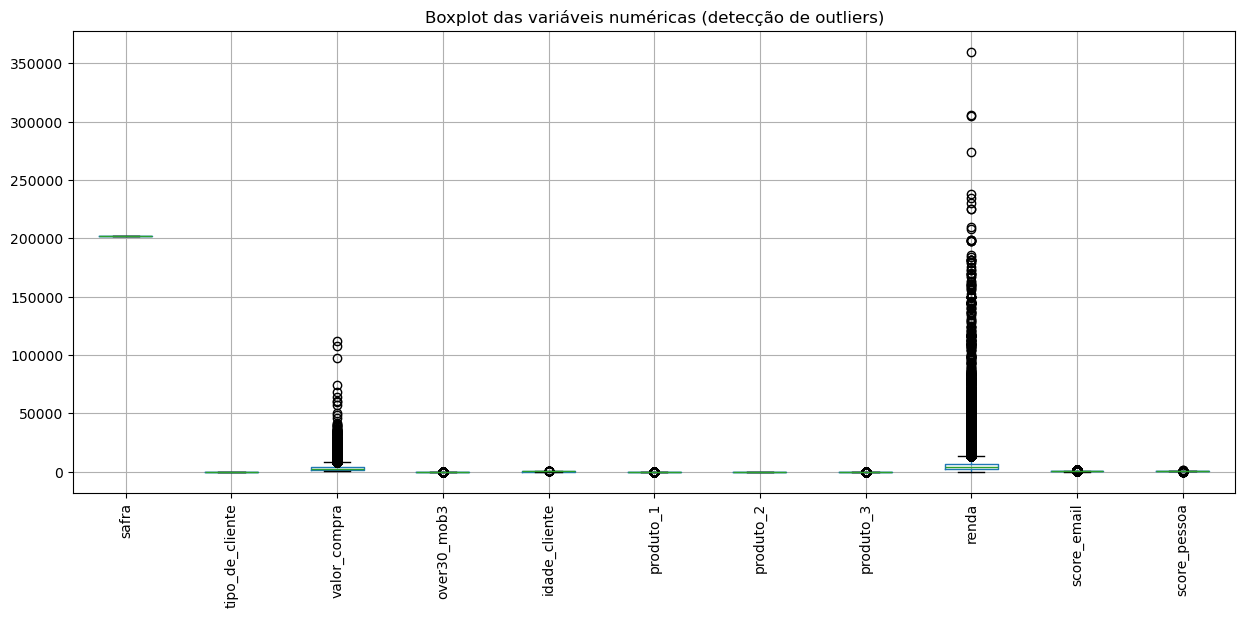

In [13]:
# Visualização com boxplot
plt.figure(figsize=(15,6))
df[num_cols].boxplot(rot=90)
plt.title("Boxplot das variáveis numéricas (detecção de outliers)")
plt.show()

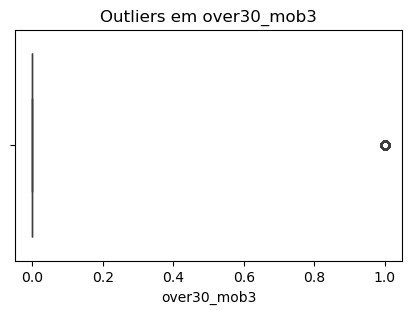

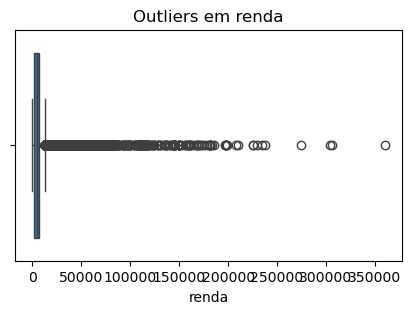

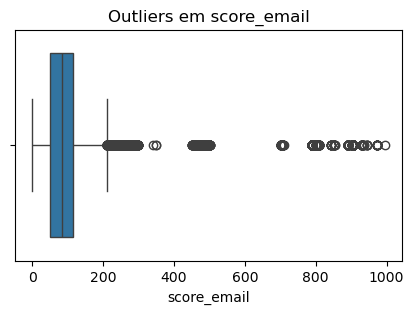

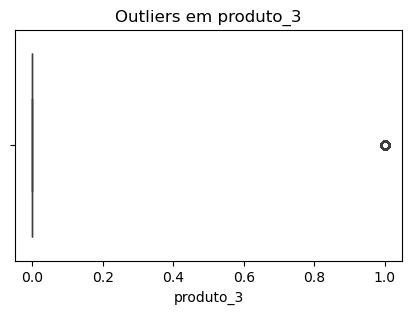

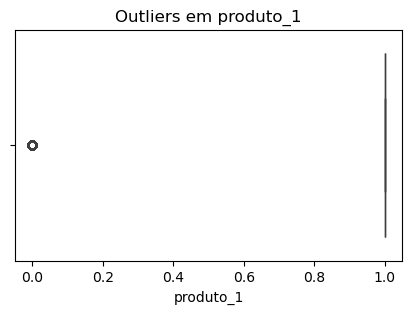

In [14]:
# Detectar outliers pelo método IQR
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    
    return len(outliers), lower, upper

outliers_summary = []

for col in num_cols:
    n_outliers, lower, upper = detect_outliers_iqr(df, col)
    outliers_summary.append([col, n_outliers, round(lower,2), round(upper,2)])

#
outliers_df = pd.DataFrame(outliers_summary, columns=["Variável", "Qtd_Outliers", "Limite_Inferior", "Limite_Superior"])

#
outliers_df["Percentual_Outliers"] = (outliers_df["Qtd_Outliers"] / len(df)) * 100
outliers_df.sort_values("Percentual_Outliers", ascending=False)

#
top_outliers = outliers_df.sort_values("Qtd_Outliers", ascending=False).head(5)["Variável"]

#
for col in top_outliers:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers em {col}")
    plt.show()

# **Parte 6.2 - Detectar outliers pelo método Z-Score**

In [15]:
# Tratar com método do Z-Score
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

#
num_cols = num_cols.drop("over30_mob3")

#
num_cols

Index(['safra', 'tipo_de_cliente', 'valor_compra', 'idade_cliente',
       'produto_1', 'produto_2', 'produto_3', 'renda', 'score_email',
       'score_pessoa'],
      dtype='object')

In [16]:
# Calcular Z-score
z_scores = np.abs(stats.zscore(df[num_cols]))

# dataframe indicando outliers
outliers_mask = (z_scores > 3)

outliers_count = outliers_mask.sum(axis=0)

outliers_df = pd.DataFrame({
    "Variavel": num_cols,
    "Qtd_Outliers": outliers_count,
    "Percentual_Outliers": (outliers_count / len(df)) * 100
})

outliers_df.sort_values("Qtd_Outliers", ascending=False)

,Variavel,Qtd_Outliers,Percentual_Outliers
produto_3,produto_3,2526,7.691371
produto_1,produto_1,2049,6.238962
score_email,score_email,726,2.210584
valor_compra,valor_compra,560,1.705134
renda,renda,552,1.680775
idade_cliente,idade_cliente,78,0.237501
score_pessoa,score_pessoa,72,0.219231
safra,safra,0,0.000000
tipo_de_cliente,tipo_de_cliente,0,0.000000
produto_2,produto_2,0,0.000000


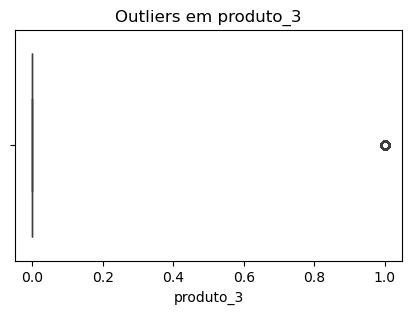

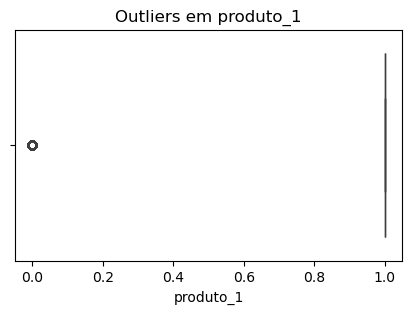

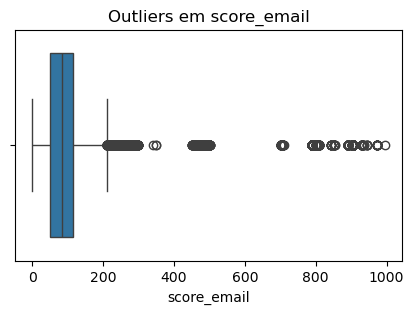

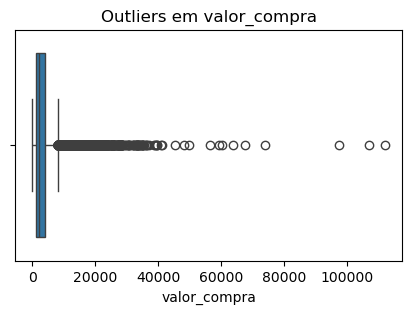

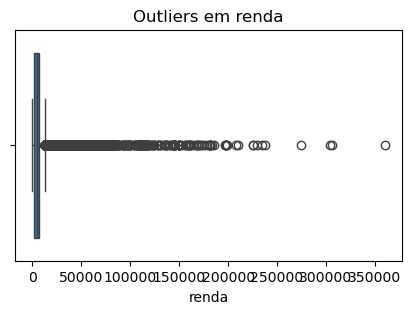

In [17]:
top_vars = outliers_df.sort_values("Qtd_Outliers", ascending=False).head(5)["Variavel"]

for col in top_vars:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers em {col}")
    plt.show()

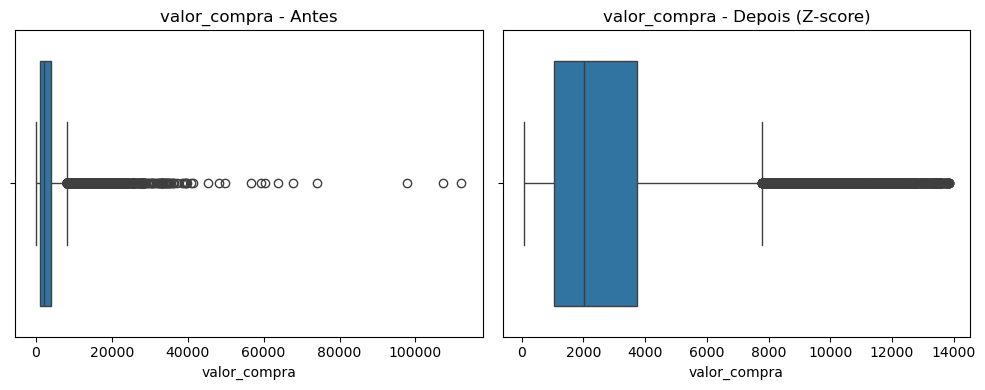

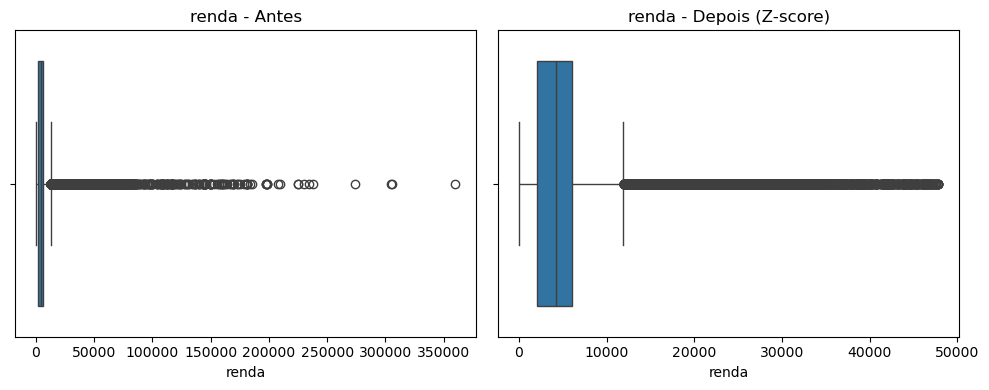

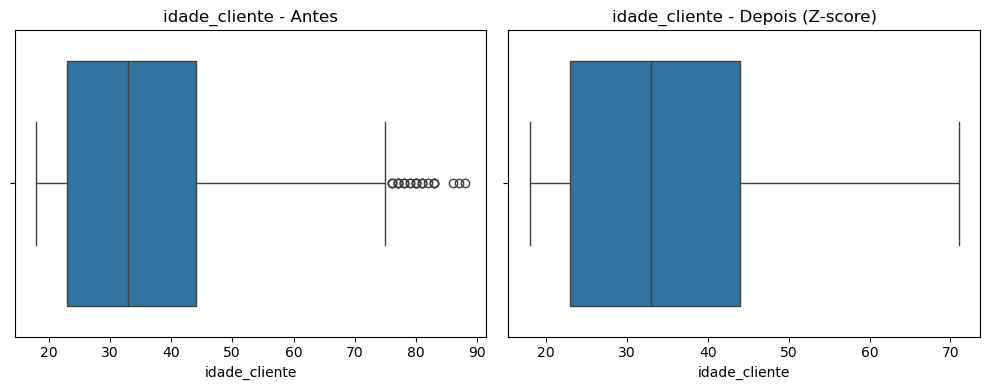

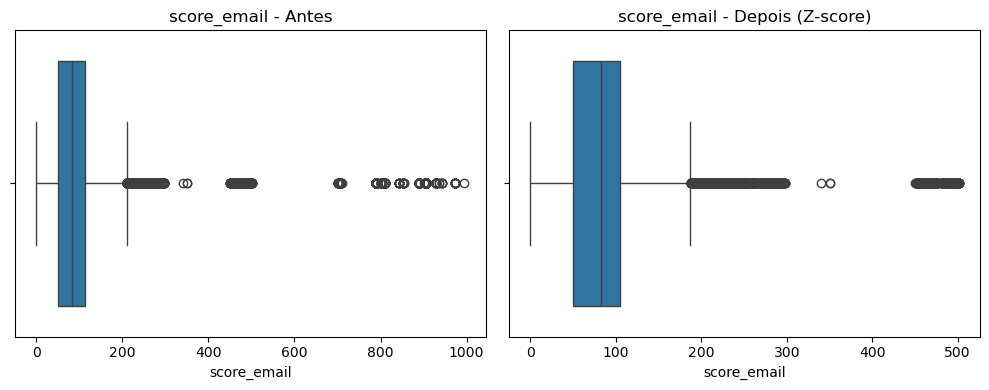

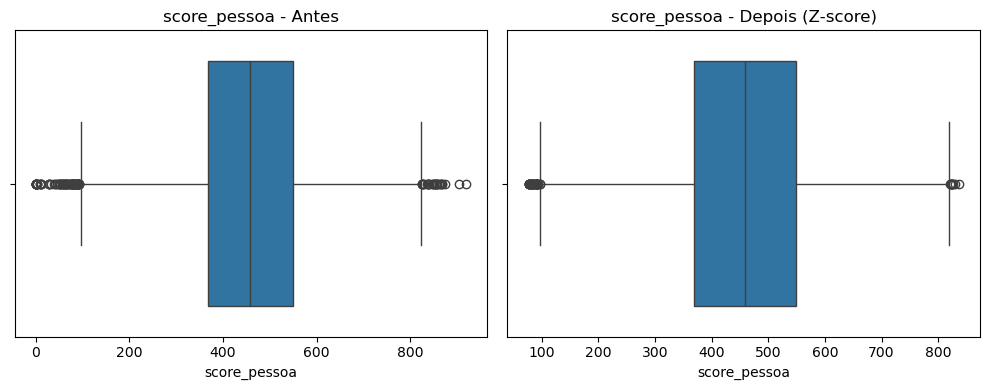

In [18]:
#
cols_zscore = ["valor_compra", "renda", "idade_cliente", "score_email", "score_pessoa"]

#
df_zscore = df.copy()
threshold = 3

# Aplicar Z-score (winsorização pela mediana)
for col in cols_zscore:
    z = np.abs(stats.zscore(df_zscore[col]))
    df_zscore[col] = np.where(
        z > threshold,
        df_zscore[col].median(),
        df_zscore[col]
    )

# Plotar Antes vs Depois para cada variável
for col in cols_zscore:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    sns.boxplot(x=df[col], ax=ax[0])
    ax[0].set_title(f"{col} - Antes")

    sns.boxplot(x=df_zscore[col], ax=ax[1])
    ax[1].set_title(f"{col} - Depois (Z-score)")

    plt.tight_layout()
    plt.show()

**Análise**

- O tratamento de outliers foi realizado utilizando o método do Z-score, considerando valores com |z| > 3 como extremos.

- O procedimento foi aplicado apenas às variáveis contínuas (valor_compra, renda, idade_cliente, score_email e score_pessoa).

- Os valores identificados como outliers foram substituídos pela mediana da respectiva variável, reduzindo o impacto de valores extremos sem remover observações do conjunto de dados.

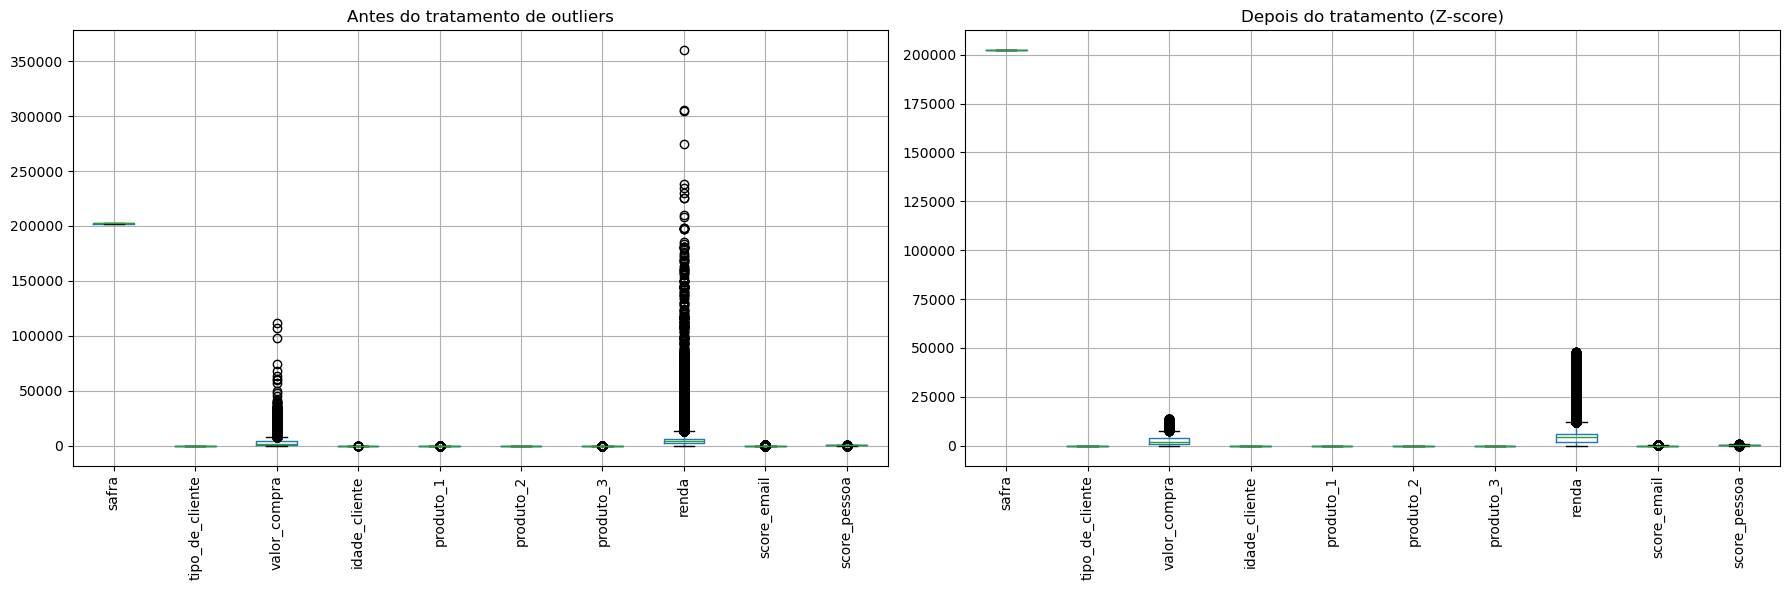

In [19]:
# Selecionar colunas numéricas (exceto target se quiser)
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Opcional: remover coluna alvo do tratamento
num_cols = [col for col in num_cols if col != "over30_mob3"]

# Copiar dataframe
df_zscore = df.copy()

threshold = 3

# Aplicar Z-score em todas as colunas numéricas
for col in num_cols:
    z = np.abs(stats.zscore(df_zscore[col], nan_policy='omit'))
    df_zscore[col] = np.where(z > threshold,
                               df_zscore[col].median(),
                               df_zscore[col])

# Plot antes e depois
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Antes
df[num_cols].boxplot(rot=90, ax=ax[0])
ax[0].set_title("Antes do tratamento de outliers")

# Depois
df_zscore[num_cols].boxplot(rot=90, ax=ax[1])
ax[1].set_title("Depois do tratamento (Z-score)")

plt.tight_layout()
plt.show()

**Análise Antes e Depois do Tratamento de Outliers (Z-score)**

O gráfico apresenta a comparação entre a distribuição das variáveis numéricas antes e após o tratamento de outliers utilizando o método do **Z-score (threshold = 3)**.

**Antes do tratamento**

* Observa-se grande concentração de valores extremos principalmente nas variáveis:

  * `valor_compra`
  * `renda`
  * `id_trx`
* Essas variáveis apresentam caudas longas e muitos pontos fora dos limites do boxplot, indicando forte assimetria e presença de outliers.
* Tais valores podem impactar negativamente modelos de machine learning, principalmente algoritmos sensíveis à escala (ex: regressão logística, KNN, redes neurais).

**Depois do tratamento (Z-score)**

* Os valores extremos foram substituídos pela **mediana da variável**, reduzindo significativamente a dispersão.
* As distribuições tornaram-se mais compactas e estáveis.
* Houve redução clara de:

  * variância excessiva,
  * influência de observações anômalas,
  * distorções nos boxplots.

**Observações importantes:**

* A variável alvo `over30_mob3` não foi tratada, pois é binária (0/1) e não representa um valor contínuo sujeito a outliers.
* Variáveis categóricas codificadas (ex: `produto_1`, `produto_2`, `produto_3`) não sofreram impacto relevante, pois já estão em domínio discreto.

**Conclusão**

O tratamento de outliers via Z-score contribuiu para:

* melhorar a qualidade dos dados,
* tornar as distribuições mais homogêneas,
* reduzir ruídos extremos,
* preparar a base para aplicação de modelos preditivos de forma mais robusta.

Este passo é essencial antes da etapa de modelagem, principalmente em problemas de risco de crédito e inadimplência.

# **Parte 7 - Feature Engineering (LabelEncoderEncoding)**

In [20]:
# Identificar colunas categóricas
cat_cols = df.select_dtypes(include=["object", "bool"]).columns
cat_cols

Index(['provedor_email', 'uf', 'dia_semana'], dtype='object')

In [21]:
#
le = LabelEncoder()

#
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

df.dtypes

safra                       int64
data_compra        datetime64[ns]
hora_da_compra              int32
tipo_de_cliente             int64
valor_compra              float64
over30_mob3                 Int64
provedor_email              int32
idade_cliente             float64
produto_1                   int64
produto_2                   int64
produto_3                   int64
uf                          int32
renda                     float64
score_email               float64
score_pessoa              float64
dia_semana                  int32
dtype: object

In [22]:
# Visualizando dataset
df

,safra,data_compra,hora_da_compra,tipo_de_cliente,valor_compra,over30_mob3,provedor_email,idade_cliente,produto_1,produto_2,produto_3,uf,renda,score_email,score_pessoa,dia_semana
0,202212,2022-12-30,0,1,1085.87,0,297,33.0,1,0,0,26,1600.0,82.0,309.0,0
1,202303,2023-03-03,0,1,1686.34,0,297,34.0,1,0,0,26,4250.0,85.0,322.0,0
2,202302,2023-02-02,0,1,2807.66,0,635,28.0,1,0,0,26,1700.0,82.0,514.0,4
3,202303,2023-03-27,0,1,333.92,1,255,53.0,1,0,0,18,2950.0,50.0,441.0,1
4,202303,2023-03-06,0,1,2721.98,0,297,34.0,1,1,1,4,3650.0,190.0,474.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32837,202303,2023-03-24,0,2,6431.54,0,255,28.0,1,1,0,0,4250.0,5.0,341.0,0
32838,202211,2022-11-19,0,2,1702.78,1,726,33.0,1,0,0,26,1500.0,137.0,290.0,2
32839,202212,2022-12-10,0,2,6515.57,0,297,39.0,1,1,0,11,7150.0,90.0,527.0,2
32840,202301,2023-01-29,0,2,1320.00,0,255,34.0,1,0,0,26,3700.0,79.0,483.0,3


# Parte 7 - Divisão x e y

In [23]:
#
target = "over30_mob3"

#
cols_drop = ["over30_mob3", "id_trx", "data_compra"]  

In [24]:
#
X = df.drop(columns=cols_drop, errors="ignore")

#
y = df[target]

# **Parte 8 - Train / Test split**

In [25]:
#
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# **Parte 9 - SMOTE**

In [26]:
#
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Antes do SMOTE:")
print(y_train.value_counts())

print("Depois do SMOTE:")
print(pd.Series(y_train_res).value_counts())

smote

Antes do SMOTE:
over30_mob3
0    22949
1     3324
Name: count, dtype: Int64
Depois do SMOTE:
over30_mob3
0    22949
1    22949
Name: count, dtype: Int64


SMOTE(random_state=42)

In [27]:
# Transformação legítima
df["ano"] = df["data_compra"].dt.year
df["mes"] = df["data_compra"].dt.month
df["dia"] = df["data_compra"].dt.day
df["dia_semana"] = df["data_compra"].dt.weekday

#
df = df.drop(columns=["data_compra"])

#
df

,safra,hora_da_compra,tipo_de_cliente,valor_compra,over30_mob3,provedor_email,idade_cliente,produto_1,produto_2,produto_3,uf,renda,score_email,score_pessoa,dia_semana,ano,mes,dia
0,202212,0,1,1085.87,0,297,33.0,1,0,0,26,1600.0,82.0,309.0,4,2022,12,30
1,202303,0,1,1686.34,0,297,34.0,1,0,0,26,4250.0,85.0,322.0,4,2023,3,3
2,202302,0,1,2807.66,0,635,28.0,1,0,0,26,1700.0,82.0,514.0,3,2023,2,2
3,202303,0,1,333.92,1,255,53.0,1,0,0,18,2950.0,50.0,441.0,0,2023,3,27
4,202303,0,1,2721.98,0,297,34.0,1,1,1,4,3650.0,190.0,474.0,0,2023,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32837,202303,0,2,6431.54,0,255,28.0,1,1,0,0,4250.0,5.0,341.0,4,2023,3,24
32838,202211,0,2,1702.78,1,726,33.0,1,0,0,26,1500.0,137.0,290.0,5,2022,11,19
32839,202212,0,2,6515.57,0,297,39.0,1,1,0,11,7150.0,90.0,527.0,5,2022,12,10
32840,202301,0,2,1320.00,0,255,34.0,1,0,0,26,3700.0,79.0,483.0,6,2023,1,29


# **Parte 10 - Modelo machine learning**

# **Parte 10.1 - Modelo machine learning Hyperparameter Tuning com K-Fold**

In [35]:
%%time

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", LGBMClassifier(
        class_weight="balanced",
        random_state=42
    ))
])

# Hyperparameter space
param_dist = {
    "model__n_estimators": [300, 500, 800],
    "model__learning_rate": [0.01, 0.03, 0.05],
    "model__num_leaves": [31, 63, 127],
    "model__max_depth": [-1, 10, 20],
    "model__min_child_samples": [20, 50, 100],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0]
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1
)

# tqdm progress bar
total_fits = 40 * cv.get_n_splits()

with tqdm_joblib(tqdm(desc="Hyperparameter Tuning (LightGBM)", total=total_fits)):
    search.fit(X, y)

# Resultados
print("="*60)
print("Melhores parâmetros:")
print(search.best_params_)
print(f"Melhor ROC AUC (CV): {search.best_score_:.4f}")

Hyperparameter Tuning (LightGBM):   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 28687, number of negative: 28687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 57374, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros:
{'model__subsample': 0.8, 'model__num_leaves': 127, 'model__n_estimators': 500, 'model__min_child_samples': 20, 'model__max_depth': -1, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.7}
Melhor ROC AUC (CV): 0.6756
CPU times: total: 55.3 s
Wall time: 6min 37s


In [36]:
# Salvar modelo
joblib.dump(
    best_model,
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\Case_tecnico_Koin\models\modelo_turing\modelo_tuned_lightgbm_kfold.pkl"
)

print("Modelo salvo com sucesso.")

# Resultados
print("="*60)
print("MELHOR MODELO (LightGBM + K-Fold)")
print("="*60)
print("Melhores parâmetros:")
print(search.best_params_)
print(f"Melhor ROC AUC (CV): {search.best_score_:.4f}")

#
best_model = search.best_estimator_

Modelo salvo com sucesso.
MELHOR MODELO (LightGBM + K-Fold)
Melhores parâmetros:
{'model__subsample': 0.8, 'model__num_leaves': 127, 'model__n_estimators': 500, 'model__min_child_samples': 20, 'model__max_depth': -1, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.7}
Melhor ROC AUC (CV): 0.6756


# Parte 11 - Metricas e avaliações

In [40]:
# Avaliação com threshold

threshold = 0.30

y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [42]:
# pegar o melhor modelo do tuning
best_lgb = search.best_estimator_

threshold = 0.30

# Probabilidades
y_proba = best_lgb.predict_proba(X_test)[:, 1]

# Predição com threshold
y_pred = (y_proba >= threshold).astype(int)

In [43]:
#
print("ROC AUC Teste:", roc_auc_score(y_test, y_proba))

ROC AUC Teste: 0.9648600605921047


In [44]:
# Teste de thresholds
print("\nAvaliação por threshold:")
thresholds = np.arange(0.1, 0.9, 0.1)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    
    print(f"Threshold {t:.2f} | Accuracy={acc:.3f} | Recall={recall:.3f} | F1={f1:.3f}")


Avaliação por threshold:
Threshold 0.10 | Accuracy=0.612 | Recall=0.993 | F1=0.393
Threshold 0.20 | Accuracy=0.856 | Recall=0.948 | F1=0.626
Threshold 0.30 | Accuracy=0.933 | Recall=0.812 | F1=0.754
Threshold 0.40 | Accuracy=0.937 | Recall=0.602 | F1=0.706
Threshold 0.50 | Accuracy=0.917 | Recall=0.379 | F1=0.536
Threshold 0.60 | Accuracy=0.898 | Recall=0.205 | F1=0.337
Threshold 0.70 | Accuracy=0.884 | Recall=0.083 | F1=0.153
Threshold 0.80 | Accuracy=0.877 | Recall=0.025 | F1=0.049


In [45]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      5738
         1.0       0.70      0.81      0.75       831

    accuracy                           0.93      6569
   macro avg       0.84      0.88      0.86      6569
weighted avg       0.94      0.93      0.94      6569



In [46]:
#
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

#
print(f"Accuracy: {acc:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC: {auc:.3f}")


Accuracy: 0.933
Recall: 0.812
F1-score: 0.754
ROC AUC: 0.965


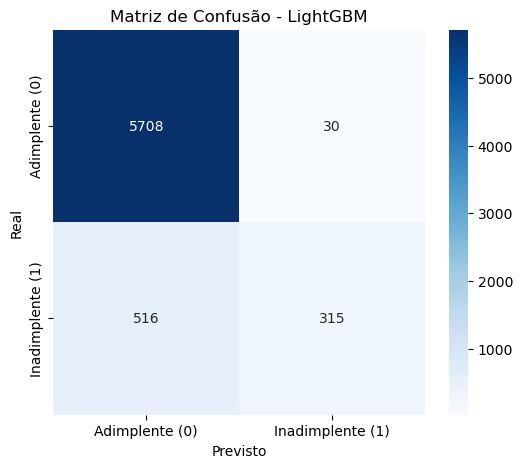

In [47]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)

labels = ["Adimplente (0)", "Inadimplente (1)"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Matriz de Confusão - LightGBM")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

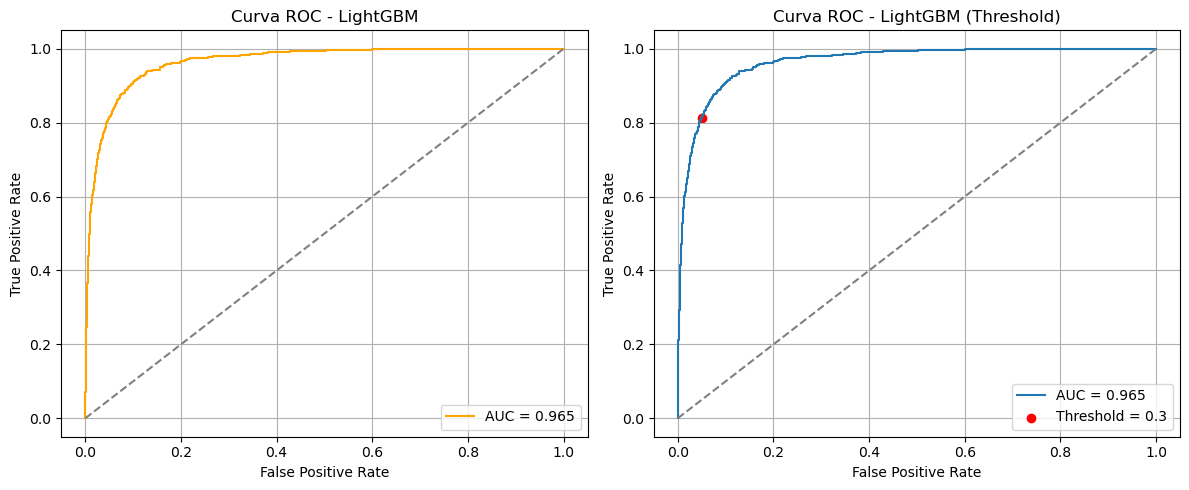

In [51]:
# Melhor modelo
best_lgb = search.best_estimator_

# Probabilidades
y_proba = best_lgb.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Threshold escolhido
threshold = 0.30
idx = np.argmin(np.abs(thresholds - threshold))

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Gráfico 1: ROC padrão
axes[0].plot(fpr, tpr, color="orange", label=f"AUC = {roc_auc:.3f}")
axes[0].plot([0,1],[0,1],"--", color="gray")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("Curva ROC - LightGBM")
axes[0].legend()
axes[0].grid()

# Gráfico 2: ROC com threshold
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
axes[1].scatter(fpr[idx], tpr[idx], color="red", label=f"Threshold = {threshold}")
axes[1].plot([0,1],[0,1],'--', color="gray")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Curva ROC - LightGBM (Threshold)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()